# Testing
### Altersklassen der Bewohnenden nach Gebäudeeigentum und Stadtquartieren in der Stadt Zürich seit 2008
Diese Daten zeigen die Personenzahl und deren Altersverteilung nach Stadtquartier und Gebäude-Eigentumsgruppe in der Stadt Zürich. Die Daten liegen ab dem Jahr 2008 jährlich vor. Bitte beachten Sie für das korrekte Verständnis zu den Daten die unten aufgeführten weiteren Erläuterungen in der Rubrik «Bemerkungen».

Datum: 15.03.2022

### Importiere die notwendigen Packages

In [72]:
#%pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly leafmap

In [73]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
#from datetime import datetime
import datetime
import geopandas as gpd
import folium 
import seaborn as sns


import requests
import io

In [74]:
SSL_VERIFY = False
# evtl. SSL_VERIFY auf False setzen wenn die Verbindung zu https://www.gemeinderat-zuerich.ch nicht klappt (z.B. wegen Proxy)
# Um die SSL Verifikation auszustellen, bitte die nächste Zeile einkommentieren ("#" entfernen)
# SSL_VERIFY = False

In [75]:
if not SSL_VERIFY:
    import urllib3
    urllib3.disable_warnings()

Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [76]:
#pd.options.display.float_format = lambda x : '{:,.1f}'.format(x) if (np.isnan(x) | np.isinf(x)) else '{:,.0f}'.format(x) if int(x) == x else '{:,.1f}'.format(x)
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [77]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")


Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [78]:
#now = datetime.now() 
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(aktuellesJahr, 
      aktuellerMonat,
    'datenstand: ', selectedMonat,
     int_times)


2022 3 datenstand:  1 time.struct_time(tm_year=2022, tm_mon=3, tm_mday=15, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=1, tm_yday=74, tm_isdst=-1)


Berechne die Variable Epoche um später das SAS-Datum in ein Unix-Datum umzuwandeln. Bei SAS beginnt die Epoche am 1.1.1960. Bei Unix am 1.1.1970.
Diese Variable wird beim CSV-Import benötigt.

In [79]:
epoch = datetime.datetime(1960, 1, 1)

### Setze einige Pfadvariabeln

- Der Packagename ist eigentlich der **Verzeichnisname** unter dem die Daten und Metadaten auf der Dropzone abgelegt werden.
- Definiert wird er bei SASA-Prozessen auf dem **Produkte-Sharepoint ([Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/PersonalViews.aspx?PageView=Personal&ShowWebPart={6087A3E7-8AC8-40BA-8278-DECFACE124FF}))**.
- Der Packagename wird auf CKAN teil der URL, daher ist die exakte Schreibweise wichtig.

Beachte: im Packagename müssen alle Buchstaben **klein** geschrieben werden. Dies weil CKAN aus grossen kleine Buchstaben macht.

**BITTE HIER ANPASSEN**

In [80]:
package_name = "bau_best_geb_ea_pers_altersgruppe_quartier_jahr_od6983"

In [81]:
dataset_name = "BAU698OD6983.csv"

**Statische Pfade in DWH-Dropzones**

In [82]:
dropzone_path_integ = r"\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH"

In [83]:
dropzone_path_prod = r"\\szh\ssz\applikationen\OGD_Dropzone\DWH"

**Statische Pfade CKAN-URLs**

In [84]:
ckan_integ_url ="https://data.integ.stadt-zuerich.ch/dataset/int_dwh_"

In [85]:
ckan_prod_url ="https://data.stadt-zuerich.ch/dataset/"

### Checke die Metadaten auf der CKAN INTEG- oder PROD-Webseite

Offenbar lassen sich aktuell im Markdownteil keine Variabeln ausführen, daher gehen wir wie unten gezeigt vor. Siehe dazu: https://data-dive.com/jupyterlab-markdown-cells-include-variables
Instead of setting the cell to Markdown, create Markdown from withnin a code cell! We can just use python variable replacement syntax to make the text dynamic

In [86]:
from IPython.display import Markdown as md

In [87]:
md(" **1. Dataset auf INTEG-Datakatalog:** Link {} ".format(ckan_integ_url+package_name))

 **1. Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bau_best_geb_ea_pers_altersgruppe_quartier_jahr_od6983 

In [88]:
md(" **2. Dataset auf PROD-Datakatalog:** Link {} ".format(ckan_prod_url+package_name))

 **2. Dataset auf PROD-Datakatalog:** Link https://data.stadt-zuerich.ch/dataset/bau_best_geb_ea_pers_altersgruppe_quartier_jahr_od6983 

### Importiere einen Datensatz 

Definiere zuerst folgende Werte:
1) Kommt der Datensatz von PROD oder INTEG?
2) Beziehst Du den Datensatz direkt ab der DROPZONE oder aus dem INTERNET?

In [89]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "integ"; #prod vs something else
data_source = "web"; #dropzone vs something else
print(status+" - "+ data_source)

integ - web


In [90]:
# Filepath
if status == "prod":
    if data_source == "dropzone":
            fp = dropzone_path_prod+"\\"+ package_name +"\\"+dataset_name
            print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_prod_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)
else:
    if data_source == "dropzone":
        fp = dropzone_path_integ+"\\"+ package_name +"\\"+dataset_name
        print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_integ_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)


fp lautet:https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bau_best_geb_ea_pers_altersgruppe_quartier_jahr_od6983/download/BAU698OD6983.csv


Beachte, wie das SAS Datum (ohne Format) in ein UNIX Datum umgerechnet und als Datumsformat dargestellt wird! Siehe dazu `https://stackoverflow.com/questions/26923564/convert-sas-numeric-to-python-datetime`

In [91]:
# Read the data
if data_source == "dropzone":
    data2betested = pd.read_csv(
        fp
        , sep=','
        ,parse_dates=['StichtagDatJahr']
        ,low_memory=False
    )
    print("dropzone")
else:
    r = requests.get(fp, verify=False)  
    r.encoding = 'utf-8'
    data2betested = pd.read_csv(
        io.StringIO(r.text)
        ,parse_dates=['StichtagDatJahr']
        # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
        #, date_parser=lambda s: epoch + datetime.timedelta(days=int(s))
        ,low_memory=False)
    print("web")

data2betested.dtypes

web


StichtagDatJahr    datetime64[ns]
QuarSort18                  int64
QuarLang18                 object
KreisSort                   int64
KreisLang                  object
EigGruSort                  int64
EigGruLang                 object
AnzGebMitPers               int64
PersTotal                   int64
Alter0009                   int64
Alter1019                   int64
Alter2029                   int64
Alter3039                   int64
Alter4049                   int64
Alter5059                   int64
Alter6069                   int64
Alter7079                   int64
Alter80um                   int64
dtype: object

Berechne weitere Attribute falls notwendig

In [92]:
data2betested = (
    data2betested
    .copy()
    .assign(
        #Aktualisierungs_Datum_str= lambda x: x.Aktualisierungs_Datum.astype(str),
        StichtagDatJahr_str = lambda x: x.StichtagDatJahr.astype(str),
    )
    .sort_values('StichtagDatJahr', ascending=False)
    )
data2betested.dtypes

StichtagDatJahr        datetime64[ns]
QuarSort18                      int64
QuarLang18                     object
KreisSort                       int64
KreisLang                      object
EigGruSort                      int64
EigGruLang                     object
AnzGebMitPers                   int64
PersTotal                       int64
Alter0009                       int64
Alter1019                       int64
Alter2029                       int64
Alter3039                       int64
Alter4049                       int64
Alter5059                       int64
Alter6069                       int64
Alter7079                       int64
Alter80um                       int64
StichtagDatJahr_str            object
dtype: object

### Einfache Datentests

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [93]:
#data2betested.head(6)

In [94]:
data2betested.dtypes

StichtagDatJahr        datetime64[ns]
QuarSort18                      int64
QuarLang18                     object
KreisSort                       int64
KreisLang                      object
EigGruSort                      int64
EigGruLang                     object
AnzGebMitPers                   int64
PersTotal                       int64
Alter0009                       int64
Alter1019                       int64
Alter2029                       int64
Alter3039                       int64
Alter4049                       int64
Alter5059                       int64
Alter6069                       int64
Alter7079                       int64
Alter80um                       int64
StichtagDatJahr_str            object
dtype: object

In [95]:
data2betested.shape

(1624, 19)

Beschreibe einzelne Attribute

In [96]:
data2betested.describe()

,QuarSort18,KreisSort,EigGruSort,AnzGebMitPers,PersTotal,Alter0009,Alter1019,Alter2029,Alter3039,Alter4049,Alter5059,Alter6069,Alter7079,Alter80um
count,1624,1624,1624,1624,1624,1624,1624,1624,1624,1624,1624,1624,1624,1624
mean,69,7,2,310,3517,329,248,588,731,532,404,288,217,181
std,35,3,1,288,2754,291,255,532,631,411,311,225,184,175
min,10,1,1,6,118,1,1,8,7,8,11,10,1,0
25%,41,4,2,102,1313,106,72,157,208,203,160,109,72,40
50%,71,7,2,204,2726,226,162,432,548,402,302,227,163,127
75%,101,10,3,424,5677,502,345,881,1120,837,623,435,329,273
max,123,12,4,1274,12181,1446,1519,2691,3231,1941,1558,1081,956,962


Wie viele Nullwerte gibt es im Datensatz?

In [97]:
data2betested.isnull().sum()

StichtagDatJahr        0
QuarSort18             0
QuarLang18             0
KreisSort              0
KreisLang              0
EigGruSort             0
EigGruLang             0
AnzGebMitPers          0
PersTotal              0
Alter0009              0
Alter1019              0
Alter2029              0
Alter3039              0
Alter4049              0
Alter5059              0
Alter6069              0
Alter7079              0
Alter80um              0
StichtagDatJahr_str    0
dtype: int64

### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [98]:
data2betested = data2betested.set_index("StichtagDatJahr")

In [99]:
data2betested.info()
data2betested.index.day.unique()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1624 entries, 2021-01-01 to 2008-01-01
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   QuarSort18           1624 non-null   int64 
 1   QuarLang18           1624 non-null   object
 2   KreisSort            1624 non-null   int64 
 3   KreisLang            1624 non-null   object
 4   EigGruSort           1624 non-null   int64 
 5   EigGruLang           1624 non-null   object
 6   AnzGebMitPers        1624 non-null   int64 
 7   PersTotal            1624 non-null   int64 
 8   Alter0009            1624 non-null   int64 
 9   Alter1019            1624 non-null   int64 
 10  Alter2029            1624 non-null   int64 
 11  Alter3039            1624 non-null   int64 
 12  Alter4049            1624 non-null   int64 
 13  Alter5059            1624 non-null   int64 
 14  Alter6069            1624 non-null   int64 
 15  Alter7079            1624 non-null   

Int64Index([1], dtype='int64', name='StichtagDatJahr')

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [100]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [102]:
data2betested.loc["2018":"2021"].head(2)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

,QuarSort18,QuarLang18,KreisSort,KreisLang,EigGruSort,EigGruLang,AnzGebMitPers,...,Alter3039,Alter4049,Alter5059,Alter6069,Alter7079,Alter80um,StichtagDatJahr_str
StichtagDatJahr,,,,,,,,,,,,,,,
2021-01-01,123,Hirzenbach,12,Kreis 12,4,Im Stockwerkeigentum,20,...,85,76,63,71,35,16,2021-01-01
2021-01-01,21,Wollishofen,2,Kreis 2,1,Öffentlich/Genossenschaftlich,575,...,1023,1074,863,699,487,446,2021-01-01


### Visualisierungen nach Zeitausschnitten

#### Entwicklung Quartier Anzahl Bewohner 60-69

In [109]:
myAgg = data2betested.loc["2010":"2021"]\
    .groupby(['StichtagDatJahr', 'QuarLang18', 'QuarSort18']) \
    .agg(sum_AnzGebMitPers=('AnzGebMitPers', 'sum'), sum_Alter6069=('Alter6069', 'sum'), sum_Alter80um=('Alter80um', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg.reset_index().head(3)

,StichtagDatJahr,QuarLang18,QuarSort18,sum_AnzGebMitPers,sum_Alter6069,sum_Alter80um
0,2010-01-01,Affoltern,111,1859,1893,993
1,2010-01-01,Wollishofen,21,1816,1458,1368
2,2010-01-01,Witikon,74,1310,1347,1023


In [110]:
myTitle="Titel"

highlight = alt.selection(type='single', on='mouseover',
                          fields=['QuarLang18'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('sum_Alter6069 > 1'), title=myTitle).encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_Alter6069', axis=alt.Axis(title='Anz. Projektierte Gebäude'))
    , color=alt.Color('QuarLang18', legend=alt.Legend(title="Projektstatus", orient="right"))  
    ,tooltip=['StichtagDatJahr', 'QuarLang18','QuarSort18', 'sum_AnzGebMitPers','sum_Alter6069','sum_Alter80um']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Barcharts mit Seaborn

In [112]:
data2betested.columns

Index(['QuarSort18', 'QuarLang18', 'KreisSort', 'KreisLang', 'EigGruSort', 'EigGruLang',
       'AnzGebMitPers', 'PersTotal', 'Alter0009', 'Alter1019', 'Alter2029', 'Alter3039',
       'Alter4049', 'Alter5059', 'Alter6069', 'Alter7079', 'Alter80um', 'StichtagDatJahr_str'],
      dtype='object')

In [127]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAggBar = data2betested.loc["2014":"2021"]\
    .groupby(['StichtagDatJahr','StichtagDatJahr_str', 'KreisLang', 'KreisSort']) \
    .agg(sum_AnzGebMitPers=('AnzGebMitPers'
                            , 'sum'), sum_Alter6069=('Alter6069', 'sum')
         , sum_Alter80um=('Alter80um', 'sum')
         , sum_Alter0009=('Alter0009', sum)
         , sum_Alter1019=('Alter1019', sum)
        ) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAggBar.reset_index().head(3)

,StichtagDatJahr,StichtagDatJahr_str,KreisLang,KreisSort,sum_AnzGebMitPers,sum_Alter6069,sum_Alter80um,sum_Alter0009,sum_Alter1019
0,2014-01-01,2014-01-01,Kreis 1,1,883,635,263,276,254
1,2014-01-01,2014-01-01,Kreis 9,9,3876,4592,3184,4757,3326
2,2014-01-01,2014-01-01,Kreis 8,8,1655,1548,765,1197,920


In [128]:
#help(sns.catplot)     

In [129]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

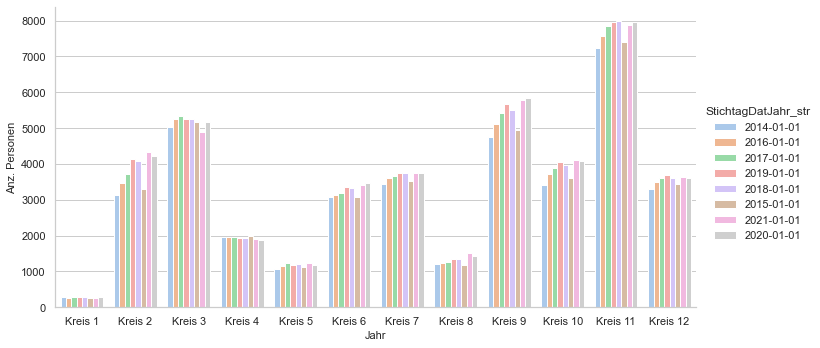

In [130]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="KreisLang"
            , y="sum_Alter0009"
            , hue="StichtagDatJahr_str"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=2
            , order=None, legend_out=True
            ,data=myAggBar.sort_values('KreisSort', ascending=True).reset_index()
           )
myHist.set_xlabels('Jahr', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Personen', fontsize=11)


In [132]:
data2betested.columns

Index(['QuarSort18', 'QuarLang18', 'KreisSort', 'KreisLang', 'EigGruSort', 'EigGruLang',
       'AnzGebMitPers', 'PersTotal', 'Alter0009', 'Alter1019', 'Alter2029', 'Alter3039',
       'Alter4049', 'Alter5059', 'Alter6069', 'Alter7079', 'Alter80um', 'StichtagDatJahr_str'],
      dtype='object')

In [137]:
myAggBar = data2betested.loc["2009":"2021"]\
    .groupby(['StichtagDatJahr','StichtagDatJahr_str', 'KreisLang', 'EigGruSort', 'EigGruLang','KreisSort']) \
    .agg(sum_AnzGebMitPers=('AnzGebMitPers', 'sum')
         , sum_Alter0009=('Alter0009', 'sum')
         , sum_Alter1019=('Alter1019', 'sum')
         , sum_Alter6069=('Alter3039', 'sum')
         , sum_Alter4049=('Alter4049', 'sum')
         , sum_Alter80um=('Alter80um', 'sum')         
        ) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAggBar.reset_index().head(3)

,StichtagDatJahr,StichtagDatJahr_str,KreisLang,EigGruSort,EigGruLang,KreisSort,sum_AnzGebMitPers,sum_Alter0009,sum_Alter1019,sum_Alter6069,sum_Alter4049,sum_Alter80um
0,2009-01-01,2009-01-01,Kreis 1,1,Öffentlich/Genossenschaftlich,1,201,102,138,176,224,170
1,2009-01-01,2009-01-01,Kreis 4,3,Natürliche Personen,4,766,710,507,3191,1835,148
2,2009-01-01,2009-01-01,Kreis 4,4,Im Stockwerkeigentum,4,67,61,48,251,189,12


In [138]:
#myAggBar.reset_index()

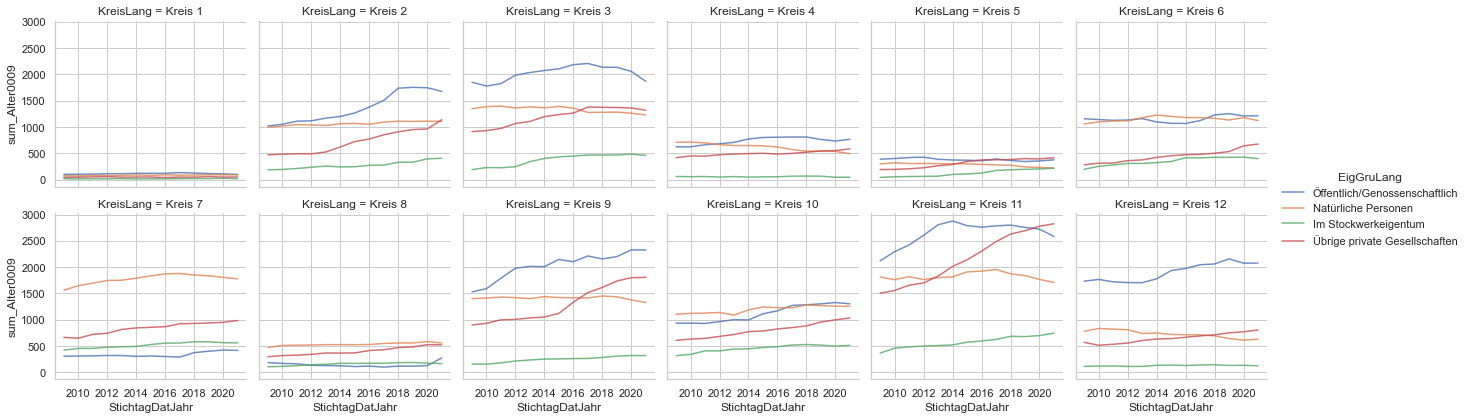

In [136]:
g = sns.FacetGrid(myAggBar.sort_values('KreisSort', ascending=True).reset_index(), col="KreisLang", hue="EigGruLang", col_wrap=6, height=3,)
#g.map(sns.scatterplot, "Jahr", "sum_ProjAnzWhg", alpha=.8)
g.map(sns.lineplot, "StichtagDatJahr","sum_Alter0009",alpha=.8)

g.add_legend()

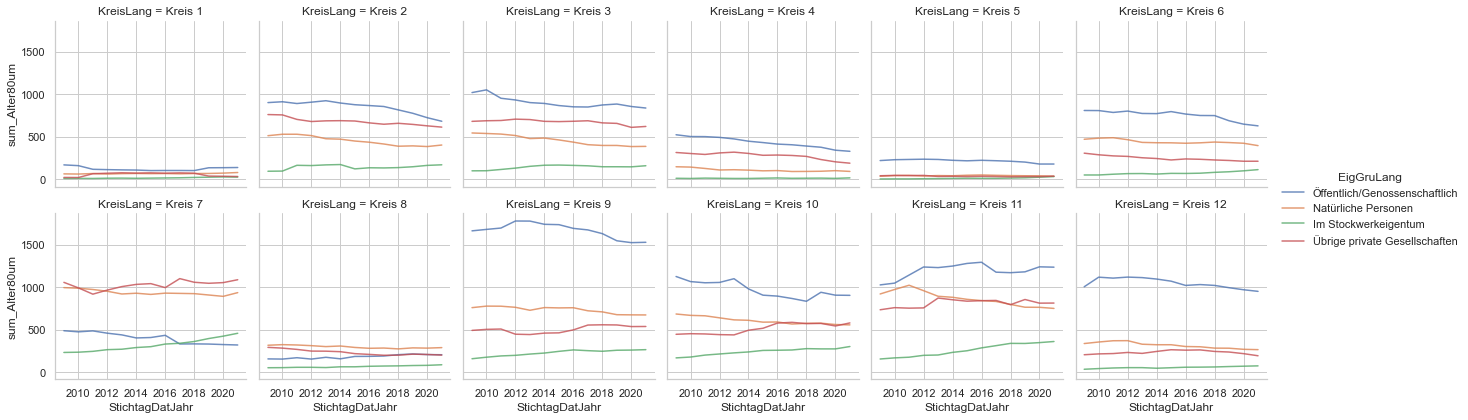

In [139]:
g = sns.FacetGrid(myAggBar.sort_values('KreisSort', ascending=True).reset_index(), col="KreisLang", hue="EigGruLang", col_wrap=6, height=3,)
#g.map(sns.scatterplot, "Jahr", "sum_ProjAnzWhg", alpha=.8)
g.map(sns.lineplot, "StichtagDatJahr","sum_Alter80um",alpha=.8)

g.add_legend()

### Daten in interaktiver Treemap zeigen
Dazu gibt es eine sehr nützliche Webseite https://plotly.com/python/treemaps/
Zu Farbskalen, siehe: https://plotly.com/python/builtin-colorscales/

#### Anzahl Wohnungen in BAUPROJEKTEN nach Projektstatus, Kreis und Quartier 2021

In [54]:
data2betested.dtypes

QuarSort           int64
QuarLang          object
KreisSort          int64
KreisLang         object
ProjStatus        object
ProjAnzGbd         int64
ProjKosten         int64
ProjRauminhalt     int64
ProjAnzWhg         int64
Whg_1_3_Zi         int64
Whg_4plus_Zi       int64
Jahr_str          object
dtype: object

In [55]:
myTreemapAgg = data2betested.loc["2021"]  \
    .groupby(['Jahr', 'QuarLang', 'KreisLang', 'ProjStatus']) \
    .agg(sum_ProjAnzGbd=('ProjAnzGbd', 'sum'),sum_ProjAnzWhg=('ProjAnzWhg', 'sum'))\
    .sort_values('sum_ProjAnzWhg', ascending=False) 

myTreemapAgg.reset_index().head(3)

,Jahr,QuarLang,KreisLang,ProjStatus,sum_ProjAnzGbd,sum_ProjAnzWhg
0,2021-01-01,Seebach,Kreis 11,Im Bau,184,1659
1,2021-01-01,Wollishofen,Kreis 2,Im Bau,63,796
2,2021-01-01,Altstetten,Kreis 9,Im Bau,113,782


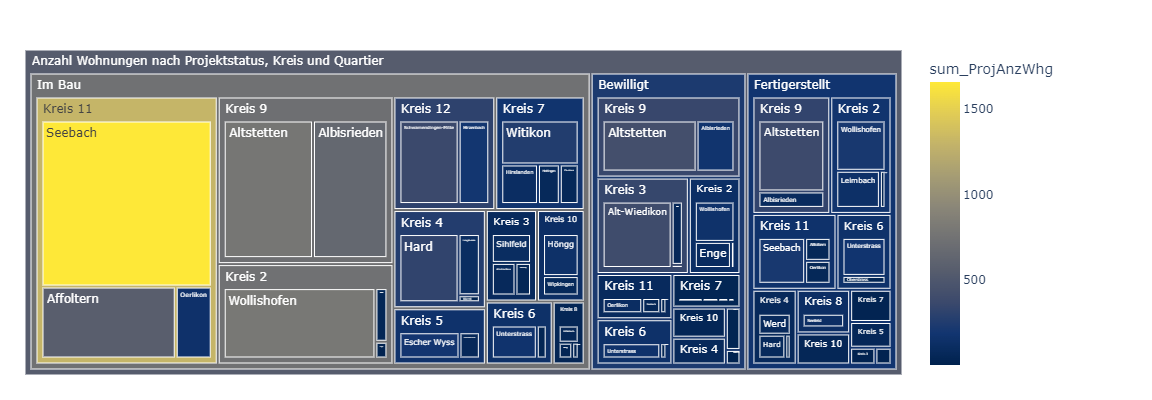

In [56]:
fig = px.treemap(myTreemapAgg.query('sum_ProjAnzWhg >0').reset_index(), path=[px.Constant("Anzahl Wohnungen nach Projektstatus, Kreis und Quartier"),'ProjStatus', 'KreisLang', 'QuarLang']
                 , values='sum_ProjAnzWhg'
                 , color='sum_ProjAnzWhg'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 #, color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='cividis'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=400
                 ,width=1100                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

#### Anzahl Wohnungen nach Projektstatus, Kreis und Quartier

In [45]:
data2betested.dtypes

QuarSort           int64
QuarLang          object
KreisSort          int64
KreisLang         object
ProjStatus        object
ProjAnzGbd         int64
ProjKosten         int64
ProjRauminhalt     int64
ProjAnzWhg         int64
Whg_1_3_Zi         int64
Whg_4plus_Zi       int64
Jahr_str          object
dtype: object

In [46]:
myTreemapAgg = data2betested.loc["2021"]  \
    .groupby(['Jahr', 'QuarLang', 'KreisLang', 'ProjStatus']) \
    .agg(sum_ProjKosten=('ProjKosten', 'sum'), sum_Whg_1_3_Zi=('Whg_1_3_Zi', 'sum'),sum_Whg_4plus_Zi=('Whg_4plus_Zi', 'sum'))\
    .sort_values('sum_Whg_1_3_Zi', ascending=False) 

myTreemapAgg.reset_index().head(3)

,Jahr,QuarLang,KreisLang,ProjStatus,sum_ProjKosten,sum_Whg_1_3_Zi,sum_Whg_4plus_Zi
0,2021-01-01,Seebach,Kreis 11,Im Bau,867143,1098,561
1,2021-01-01,Wollishofen,Kreis 2,Im Bau,320688,611,185
2,2021-01-01,Altstetten,Kreis 9,Im Bau,593275,601,181


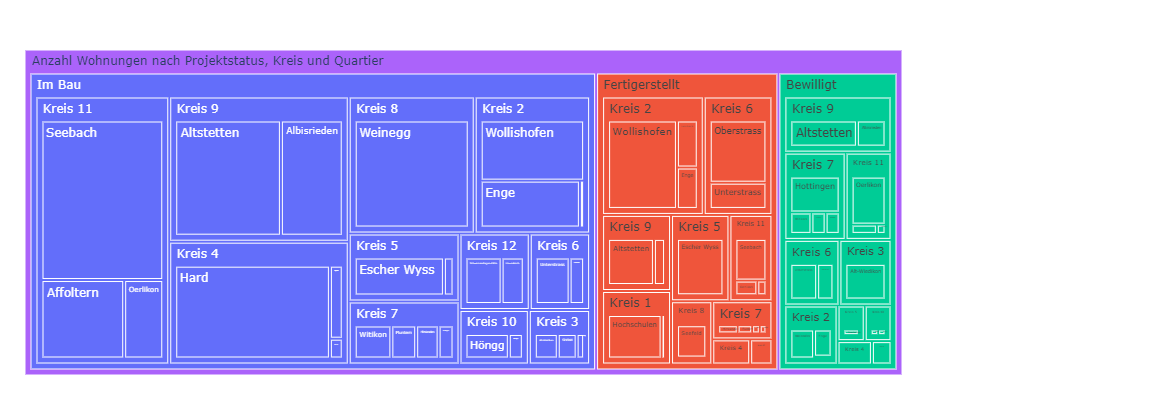

In [47]:
fig = px.treemap(myTreemapAgg.query('sum_ProjKosten >0').reset_index(), path=[px.Constant("Anzahl Wohnungen nach Projektstatus, Kreis und Quartier"),'ProjStatus', 'KreisLang', 'QuarLang']
                 , values='sum_ProjKosten'
                 , color='ProjStatus'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 #, color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='cividis'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=400
                 ,width=1100                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

In [48]:
#data2betested.dtypes

## ---------------------- hier Plausi beendet ---------------------- 

**Sharepoint als gecheckt markieren!**


Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=901&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**

---------------------- 

Liniendiagramm 
[Link zur Doku](https://altair-viz.github.io/gallery/multiline_highlight.html)

### Test: Choroplethenkarte
Importiere die Geodaten als GeoJSON

#### Stadtkreise

In [49]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
geojson_url_kreise = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Stadtkreise?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_stadtkreise_v"
adm_stadtkreise_v = gpd.read_file(geojson_url_kreise)

adm_stadtkreise_v.head(1)


,id,kname,knr,objid,geometry
0,adm_stadtkreise_v.6,Kreis 7,7,6,"POLYGON ((8.54885 47.36602, 8.54901 47.36601, ..."


#### Statistische Zonen

In [50]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
geojson_url_statzonen = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Zonen?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statzonen_map"
adm_statzonen_map = gpd.read_file(geojson_url_statzonen)

adm_statzonen_map.head(2)


,id,kname,knr,objectid,objid,qname,qnr,stzname,stznr,geometry
0,adm_statzonen_map.1,Kreis 7,7,1,154,Hirslanden,73,Hegibach,7303,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statzonen_map.2,Kreis 7,7,2,89,Hirslanden,73,Klus,7302,"POLYGON ((8.57281 47.35806, 8.57278 47.35807, ..."


#### Statistische Quartiere

In [51]:
geojson_url_quartiere = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Quartiere?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statistische_quartiere_map"
df_adm_statistische_quartiere_map = gpd.read_file(geojson_url_quartiere)

df_adm_statistische_quartiere_map.head(2)


,id,kname,knr,objectid,objid,qname,qnr,geometry
0,adm_statistische_quartiere_map.1,Kreis 7,7,1,34,Hirslanden,73,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statistische_quartiere_map.2,Kreis 8,8,2,33,Weinegg,83,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ..."


### Teste LeafMap

Mehr Infos: https://leafmap.org/leafmap/

In [52]:
m = leafmap.Map()


#m.add_geojson(geojson_url_kreise, layer_name="adm_stadtkreise_v", fill_colors=['red', 'yellow', 'green', 'orange'], info_mode=True)
m.add_gdf(df_adm_statistische_quartiere_map, layer_name='adm_statistische_quartiere_map', style={}, hover_style={}, style_callback=None, fill_colors=['black'], info_mode='on_hover', zoom_to_layer=True)
m.add_gdf(adm_stadtkreise_v, layer_name='adm_stadtkreise_v', style={}, hover_style={}, style_callback=None, fill_colors=['none'], info_mode='on_hover', zoom_to_layer=False)

m.add_legend(title='Legende', legend_dict=None, labels=None, colors=None, position='bottomright', builtin_legend=None, layer_name='adm_statistische_quartiere_map')
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

### Joins
Joine die importierten statistischen Daten des aktuellen Jahres zum Geodatensatz:

*Siehe dazu Doku zu [Geopandas](https://geopandas.org/docs/user_guide/mergingdata.html)*

In [127]:
data2betested.dtypes

StatZoneCd             int64
StatZone              object
QuarCd                 int64
QuarLang              object
KreisCd                int64
KreisLang             object
EigentumsartSort       int64
Eigentumsart          object
Whg_abgebrochen        int64
Whg_fertigerstellt     int64
dtype: object

In [137]:
myAgg = data2betested.loc["2021"]  \
    .groupby(['QuarLang', 'QuarCd']) \
    .agg(sum_Whg_abgebrochen=('Whg_abgebrochen', 'sum'),sum_Whg_fertigerstellt=('Whg_fertigerstellt', 'sum')) \
    .sort_values('sum_Whg_abgebrochen', ascending=False) 

myAgg.reset_index().head(1)


,QuarLang,QuarCd,sum_Whg_abgebrochen,sum_Whg_fertigerstellt
0,Albisrieden,91,282,89


In [138]:
# Rename attribute stznr to StatZoneSort, so the IDs have the same name
gdf_adm_statistische_quartiere_map = df_adm_statistische_quartiere_map[['geometry', 'qnr', 'qname', 'knr']].rename(columns={'qnr': 'QuarCd'})
gdf_adm_statistische_quartiere_map.head(1)

,geometry,QuarCd,qname,knr
0,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ...",73,Hirslanden,7


In [139]:
# Merge with `merge` method on shared variable (stznr und StatZoneSort):
gdf_adm_statistische_quartiere_map_joined = gdf_adm_statistische_quartiere_map.merge(myAgg, on='QuarCd')
gdf_adm_statistische_quartiere_map_joined.head(2)


,geometry,QuarCd,qname,knr,sum_Whg_abgebrochen,sum_Whg_fertigerstellt
0,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ...",73,Hirslanden,7,48,2
1,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ...",83,Weinegg,8,2,0


<AxesSubplot:>

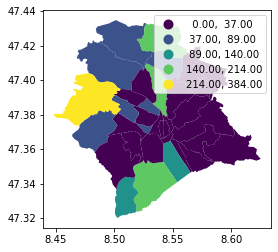

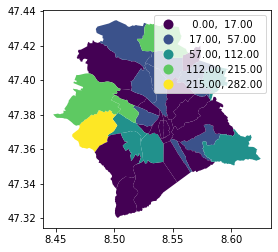

In [142]:
# Plot by StatQuartiere
# Weitere Schemes: scheme='quantiles', scheme='fisherjenks', scheme='natural_breaks',

gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', cmap='viridis', scheme='natural_breaks', legend=True )
gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='viridis', scheme='natural_breaks', legend=True )

#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='plasma', scheme='fisherjenks', legend=True )
#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', cmap='cool', scheme='quantiles', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

#
#Neuere Gallerie: https://matplotlib.org/stable/gallery/index.html

<AxesSubplot:>

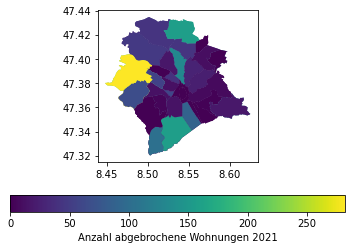

In [157]:
fig, ax = plt.subplots(1, 1)

gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', ax=ax, legend=True, legend_kwds={'label': "Anzahl abgebrochene Wohnungen 2021",'orientation': "horizontal"})
gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', ax=ax, legend=False, legend_kwds={'label': "Anzahl fertigerstellte Wohnungen 2021",'orientation': "horizontal"})

#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='viridis', scheme='natural_breaks', legend=True , ax=ax, legend_kwds={'label': "Anzahl Personen",'orientation': "horizontal"})

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html